In [287]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(1, '/media/pklein/SATA_SSD/GitHub/pypsa_utilities/eskom data/')
sys.path.insert(1, '/mnt/wsl/PHYSICALDRIVE0p1/GitHub/pypsa_utilities/eskom data/')

import data_utilities as du
import plotting_utilities as pu
import financial_utilities as fu
import xarray as xr
import cartopy.crs as ccrs
from pypsa.descriptors import get_switchable_as_dense as get_as_dense
import geopandas as gpd
import rasterio
from rasterio.plot import show
import numpy as np
from shapely.geometry import shape
import rioxarray
import atlite
import shapely
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning) 


In [292]:
def aggregate_p(n,y):
    return pd.concat(
        [
            n.generators_t.p.loc[y].sum().groupby(n.generators.carrier).sum(),
            n.storage_units_t.p.loc[y].sum().groupby(n.storage_units.carrier).sum(),
            n.stores_t.p.loc[y].sum().groupby(n.stores.carrier).sum(),
            -n.loads_t.p.loc[y].sum().groupby(n.loads.carrier).sum(),
        ]
    )


def aggregate_e_nom(n):
    return pd.concat(
        [
            (n.storage_units["p_nom_opt"] * n.storage_units["max_hours"])
            .groupby(n.storage_units["carrier"])
            .sum(),
            n.stores["e_nom_opt"].groupby(n.stores.carrier).sum(),
        ]
    )


def aggregate_p_curtailed(n,y):
    return pd.concat(
        [
            (
                (
                    n.generators_t.loc[y].p_max_pu.sum().multiply(n.generators.p_nom_opt)
                    - n.generators_t.loc[y].p.sum()
                )
                .groupby(n.generators.carrier)
                .sum()
            ),
            (
                (n.storage_units_t.inflow.loc[y].sum() - n.storage_units_t.p.loc[y].sum())
                .groupby(n.storage_units.carrier)
                .sum()
            ),
        ]
    )

In [24]:
colour_map={'onwind':'#77D1E4',
            'onwind_100MW':'#2eb8d6',
            'solar':'#FFBB4E',
            'solar_pv_1MW':'#FBDC81',
            'solar_pv_100MW':'#F99B00',
            'CSP':'#feed82',
            'battery':'#cba3cb',
            'bat_c':'#AA68AA',#CBA3CB
            'bat_d':'#AA68AA',
            'PHS':'#873f91',
            'phs_c':'#873f91',
            'phs_d':'#873f91',
            'coal':'#3C3C3C',
            'hydro':'#004F95',
            'ocgt':'#8D7867',
            'diesel':'#8D7867',
            'gas':'#8D7867',
            'OCGT':'#8D7867',
            'CCGT':'#ffa69e',
            'rmippp':'#51969B',
            'biomass':'#8C9A07',
            'nuclear':'#C84936',
            'demand_response':'#817E80',
            'loadshedding':'#DE9287'}

In [63]:
df = pd.read_excel('../data/digitized_system_eaf.xlsx',sheet_name=None,index_col=0)

In [62]:
df1 = pd.concat([df['CSIR-ambitions-2019'],pd.DataFrame(index=range(2019,2051),columns=['value'])],axis=0)['System EAF']
(0.88*df1.sort_index().interpolate()).to_clipboard()

In [ ]:
def generate_datetimeindex(start_date: str, end_date: str) -> pd.DatetimeIndex:
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    return pd.date_range(start_date, end_date, freq='1H')


# Generate the DatetimeIndex
idx = generate_datetimeindex('2009-01-01', '2021-12-31')

# Create a DataFrame with the DatetimeIndex
df = pd.DataFrame({'date': idx})

# Write the DataFrame to an Excel file
df.to_clipboard()


In [81]:
n0 = pypsa.Network('../networks/pre_CSIR-ambitions-2022_RSA_redz_lcopt_LC.nc')

INFO:pypsa.io:Imported network pre_CSIR-ambitions-2022_RSA_redz_lcopt_LC.nc has buses, carriers, generators, global_constraints, loads, storage_units
INFO:pypsa.io:Imported network pre_CSIR-ambitions-2022_RSA_redz_lcopt_LC_backup.nc has buses, carriers, generators, global_constraints, loads, storage_units


In [91]:
n1 = pypsa.Network('../networks/pre_CSIR-ambitions-2022_RSA_redz_lcopt_LC (copy).nc')

INFO:pypsa.io:Imported network pre_CSIR-ambitions-2022_RSA_redz_lcopt_LC (copy).nc has buses, carriers, generators, global_constraints, loads, storage_units


In [265]:
n = pypsa.Network('../results/networks/solved_validation-3_RSA_redz_lcopt_LC.nc')

INFO:pypsa.io:Imported network solved_validation-3_RSA_redz_lcopt_LC.nc has buses, carriers, generators, global_constraints, loads, storage_units


In [ ]:
reserve_type='total'
carriers = ['battery','PHS']
carriers=['diesel','gas','OCGT','CCGT','battery','PHS'] 
y=2030
p_nom=n.generators.p_nom_opt[n.get_active_assets('Generator',y) & n.generators.carrier.isin(carriers)].sum()+n.storage_units.p_nom_opt[n.get_active_assets('StorageUnit',y)].sum()
(p_nom-n.generators_t.p.loc[y][n.generators.p_nom_opt[n.get_active_assets('Generator',y) & n.generators.carrier.isin(carriers)].index].sum(axis=1)-n.storage_units_t.p_dispatch.loc[y].sum(axis=1)).min()

In [266]:
capacity=pd.DataFrame(np.nan,index=np.append(n.generators.carrier.unique(),n.storage_units.carrier.unique()),columns=range(n.investment_periods[0],n.investment_periods[-1]+1))       
carriers=n.generators.carrier.unique()
carriers = carriers[carriers !='load_shedding']
for y in n.investment_periods:
    capacity.loc[carriers,y]=n.generators.p_nom_opt[(n.get_active_assets('Generator',y))].groupby(n.generators.carrier).sum()

carriers=n.storage_units.carrier.unique()
for y in n.investment_periods:
    capacity.loc[carriers,y]=n.storage_units.p_nom_opt[(n.get_active_assets('StorageUnit',y))].groupby(n.storage_units.carrier).sum()

capacity.loc['OCGT',:]+=capacity.loc['gas',:]+capacity.loc['diesel',:]
capacity=capacity.T.interpolate().T
capacity=capacity.reindex(['nuclear','coal','CCGT','OCGT','hydro','PHS','biomass','onwind','CSP','solar','battery'])

In [267]:
capacity

,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
nuclear,1854.033565,1854.033565,1854.033565,1854.033565,1854.033565,1854.033565,1854.033565,1854.033565,1854.033565,1854.033565,...,1854.033565,1854.033565,927.033565,0.033565,0.033565,0.033565,0.033565,0.033565,0.033565,0.033565
coal,40216.075088,39475.633795,38735.192501,37136.260873,35537.329246,35195.412456,34853.495666,33428.598500,32003.701334,32003.850368,...,17029.676384,15444.357664,13656.912662,11869.467660,11870.202710,11870.937761,10954.977354,10039.016948,10039.293496,10039.570044
CCGT,5199.323393,5199.323393,5199.323393,5199.323393,5199.323393,5199.323393,5199.323393,5199.323393,5199.323393,5199.323393,...,5199.323393,5199.323393,5199.323393,5199.323393,5199.323393,5199.323393,5199.323393,5199.323393,5199.323393,5199.323393
OCGT,3497.338790,3613.465389,3729.591987,5166.842573,6604.093158,6607.507881,6610.922605,6612.199614,6613.476624,6615.108692,...,10568.277549,12216.967364,13766.887843,15316.808321,15575.133987,15833.459653,16778.952131,17724.444610,17728.173219,17731.901829
hydro,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,...,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000,2447.020000
PHS,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,...,7772.478779,7904.483934,7906.826018,7909.168101,7910.033212,7910.898322,7911.297586,7911.696851,7911.848423,7911.999995
biomass,193.060000,193.060000,193.060000,193.060000,193.060000,193.060000,193.060000,193.060000,193.060000,193.060000,...,193.060000,193.060000,193.060000,193.060000,193.060000,193.060000,193.060000,193.060000,181.030000,169.000000
onwind,3444.168378,4974.115636,6504.062895,8402.415758,10300.768622,11400.257770,12499.746918,14367.194976,16234.643034,16334.385662,...,36928.029138,39917.105081,42696.348597,45475.592114,46709.161936,47942.731759,49676.957264,51411.182770,52184.410968,52957.639166
CSP,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,...,600.000000,600.000000,600.000000,600.000000,525.000000,450.000000,425.000000,400.000000,400.000000,400.000000
solar,2560.746997,4268.325499,5975.904000,9421.498697,12867.093394,14617.600275,16368.107156,19188.595630,22009.084104,23135.926974,...,50893.976334,53126.660390,56340.361618,59554.062846,60932.059748,62310.056650,64298.041496,66286.026342,67864.986929,69443.947515


In [297]:
def aggregate_p(n,y):
    return pd.concat(
        [
            n.generators_t.p.loc[y].sum().groupby(n.generators.carrier).sum(),
            n.storage_units_t.p.loc[y].sum().groupby(n.storage_units.carrier).sum(),
        ]
    )

In [298]:
energy = aggregate_p(n,2022)
energy

carrier
CCGT             1.366382e+07
CSP              1.986254e+06
OCGT             3.734301e+01
biomass          9.566110e+05
coal             1.934270e+08
diesel           8.310313e+03
gas              5.616520e+03
hydro            9.531451e+06
load_shedding    2.421796e-01
nuclear          1.217929e+07
onwind           1.067975e+07
solar            4.200002e+06
PHS             -1.101595e+06
battery         -1.103027e+02
dtype: float64

In [ ]:
energy=pd.DataFrame(np.nan,index=np.append(n.generators.carrier.unique(),n.storage_units.carrier.unique()),columns=range(n.investment_periods[0],n.investment_periods[-1]+1))       
carriers=n.generators.carrier.unique()
carriers = carriers[carriers !='load_shedding']
for y in n.investment_periods:
    
    
    
    energy.loc[carriers,y]=n.generators_t.p.p_nom_opt[(n.get_active_assets('Generator',y))].groupby(n.generators.carrier).sum()

carriers=n.storage_units.carrier.unique()
for y in n.investment_periods:
    capacity.loc[carriers,y]=n.storage_units.p_nom_opt[(n.get_active_assets('StorageUnit',y))].groupby(n.storage_units.carrier).sum()

capacity.loc['OCGT',:]+=capacity.loc['gas',:]+capacity.loc['diesel',:]
capacity=capacity.T.interpolate().T
capacity=capacity.reindex(['nuclear','coal','CCGT','OCGT','hydro','PHS','biomass','onwind','CSP','solar','battery'])

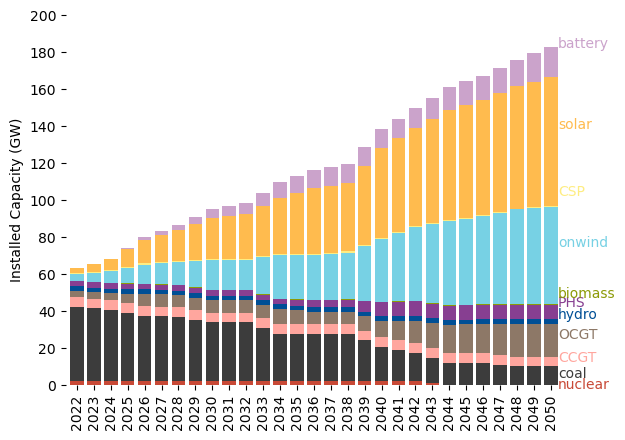

In [278]:
ax = (capacity/1000).T.plot.bar(stacked=True,color=colour_map,width=0.8)
plt.ylabel('Installed Capacity (GW)')
plt.xlabel("")
plt.ylim([0,200])
plt.yticks(range(0, 200+1, 20))  # set y-axis ticks to increments of 20

for spine in ax.spines:
    ax.spines[spine].set_visible(False)

cnt=0
height = 0     
dy = 1  # adjust this value to fine-tune the vertical spacing between annotations
for bar in ax.containers:
    end_cap = (capacity/1000).iloc[cnt,-1]
    x = len(capacity.T)-1
    y = end_cap/2+height+dy*cnt  # adjust y position based on index of the bar
    ax.annotate(
        capacity.index[cnt],
        xy=(x, y),
        xytext=(5, 0),
        textcoords="offset points",
        va="center",
        color=ax.containers[cnt][-1].get_facecolor(),
        #arrowprops=dict(arrowstyle='-', connectionstyle='angle3,angleA=0,angleB=-90', facecolor='black', width=1, headwidth=4, headlength=4),  # change arrow to line
    )
    height += end_cap
    cnt+=1

ax.legend().set_visible(False)

#ax.grid(axis='y', color='lightgray',linestyle='-.',zorder=0)  # add light grey horizontal grid lines only


In [275]:
len(capacity.T)

29

In [73]:
n.loads_t.p_set.groupby(n.snapshots.get_level_values(0)).sum()

Load,RSA
period,
2022,2.455365e+08
2025,2.571553e+08
2030,2.769605e+08
2035,2.941598e+08
2040,3.113591e+08
2045,3.285584e+08
2050,3.457576e+08


In [70]:
n.generators_t.p['RSA load_shedding'].groupby(n.generators_t.p.index.get_level_values(0)).sum()/1e6

period
2022    0.014566
2025    0.015292
2030    0.011443
2035    0.009126
2040    0.009816
2045    0.010352
2050    0.009658
Name: RSA load_shedding, dtype: float64

In [ ]:
years=n.generators_t.p.index.get_level_values(0)
n.generators_t.p[n.generators[n.generators.carrier.isin(['diesel'])].index].sum(axis=1).groupby(years).sum()/(3056*8760)

In [ ]:
n.storage_units.p_nom_opt

In [ ]:
n.storage_units_t.state_of_charge['Drakensberg'].plot()

In [ ]:
n.global_constraints[n.global_constraints['sense']=='<=']

In [ ]:
eskom_data=du.eskom_data('../data/ESK2791.csv')

In [ ]:
eskom_data['other_re_installed'].groupby(eskom_data.index.year).max().to_clipboard()

In [ ]:
eskom_data['loadshed_mlr'].groupby(eskom_data.index.year).sum().to_clipboard()

In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 


for y in [2017,2018,2019,2020,2021,2022]:
    data=df.loc['Generation Total','PCLF %']
    plt.plot(data[data.index.year==y].values)



In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 
stations=df[df.type=='coal'].index.get_level_values(0)

In [ ]:
stations

In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 
stations=df[df.type=='coal'].index.get_level_values(0).unique()
eaf=pd.DataFrame(0,index=stations,columns=range(2017,2023))
planned=pd.DataFrame(0,index=stations,columns=range(2017,2023))
unplanned=pd.DataFrame(0,index=stations,columns=range(2017,2023))
for s in stations:
    eaf.loc[s,:]=df.loc[s,'EAF %'].groupby(df.loc[s,'EAF %'].index.year).mean()
    planned.loc[s,:]=df.loc[s,'PCLF %'].groupby(df.loc[s,'PCLF %'].index.year).mean()
    unplanned.loc[s,:]=df.loc[s,'UCLF %'].groupby(df.loc[s,'UCLF %'].index.year).mean()+df.loc[s,'OCLF %'].groupby(df.loc[s,'OCLF %'].index.year).mean()

In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 
df=df[df.type=='coal']
df.index=df.index.get_level_values(1)
variable='EAF %'
type_avg=df.groupby(level=0).mean()
type_avg.drop(['MW','capacity'],axis=1)
type_avg.loc[:,variable].groupby(type_avg.index.year).mean()

In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 
stations=df[df.type=='coal'].index.get_level_values(0)

installed_capacity=pd.DataFrame(0,index=stations,columns=range(2017,2023))
for s in stations:
    for y in range(2017,2023):
        installed_capacity.loc[s,y]=df.loc[(s,str(y)),'MW'].mean()

In [ ]:
installed_capacity.to_clipboard()

In [ ]:
mean_pclf=type_avg[variable].groupby(type_avg.index.month).mean().to_clipboard()
for y in [2017,2018,2019,2020,2021,2022]:
    plt.plot(type_avg.loc[str(y),variable].values)

plt.plot(mean_pclf.values,'k--',linewidth=3)
plt.legend([2017,2018,2019,2020,2021,2022])

In [ ]:
mean_pclf=coal_plants['UCLF %'].groupby(coal_plants.index.month).mean()
for y in [2017,2018,2019,2020,2021,2022]:
    plt.plot(coal_plants.loc[str(y),'UCLF %'].values)

plt.plot(mean_pclf.values,'k--',linewidth=3)
plt.legend([2017,2018,2019,2020,2021,2022])

In [ ]:
plt.plot(eskom_data['coal_eaf'])
plt.plot(df[df.type=='coal'].groupby('Date').sum()['capacity'].divide(df[df.type=='coal'].groupby('Date').sum()['MW']))
plt.ylabel('Coal fleet EAF')

In [ ]:
n365 = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC.nc')
n365.generators.p_nom_opt[(n365.get_active_assets('Generator',2040)) & (n365.generators.carrier=='onwind')].plot.bar()

In [ ]:
n350 = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-350p.nc')
n350.generators.p_nom_opt[(n350.get_active_assets('Generator',2040)) & (n350.generators.carrier=='onwind')].plot.bar()

In [ ]:
n = pypsa.Network('../results/version-0.6/networks/solved_IRP-2019_RSA_redz_lcopt_LC.nc')

In [ ]:
n[25] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-25p.nc')
n[10] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-10p.nc')
n[5] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-5p.nc')

In [ ]:
#s={}
#s[1200] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-1200SEG.nc')
#s[2400] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-2400SEG.nc')
s[3600] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-3600SEG.nc')

In [ ]:
n={}
n[365] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC.nc')
n[350] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-350p.nc')
n[300] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-300p.nc')
n[250] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-250p.nc')
n[200] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-200p.nc')
n[150] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-150p.nc')
n[100] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-100p.nc')
n[50] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-50p.nc')
n[25] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-25p.nc')
n[10] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-10p.nc')
n[50] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-5p.nc')

In [ ]:
n.investment_period_weightings

In [ ]:
n.generators.p_nom_opt[n.get_active_assets('Generator',2025)].groupby(n.generators.carrier).sum()

In [ ]:
n.generators.p_nom_opt[n.generators.carrier=='coal']

In [ ]:
n.generators.p_nom_opt[n.generators.carrier=='solar']

In [ ]:
nodes=[5,10,25,50,100,150,200,250,300,350,365]
capacity = pd.DataFrame(0,index=n[365].generators.carrier.unique(),columns=nodes)
for node in nodes:
    p_nom_opt = n[node].generators.p_nom_opt.groupby(n365.generators.carrier).sum()
    for tech in n365.generators.carrier:
        capacity.loc[tech,node] = p_nom_opt[tech]


In [ ]:
capacity = pd.DataFrame(0,index=n[365].generators.carrier,columns=nodes)

In [ ]:
capacity.T.plot.area()

In [ ]:
supply_regions = gpd.read_file(snakemake.input.supply_regions).buffer(-0.005) #.to_crs(n.crs)
resarea = gpd.read_file(snakemake.input.resarea).to_crs(supply_regions.crs)

In [ ]:
fig, ax = plt.subplots(figsize=[7, 7], subplot_kw={"projection": ccrs.PlateCarree()})
n.plot(ax=ax, boundaries=[14, 34, -35, -22])

In [ ]:
n.plot(ax=ax)

In [ ]:
n.lines[['bus0','bus1','num_parallel','length','s_nom_min']]

In [ ]:
n.lines['s_nom_opt']-n.lines['s_nom_min']

In [ ]:
n.generators.p_nom_opt.groupby(n.generators.carrier).sum()

In [ ]:
n.storage_units.p_nom_opt.groupby(n.storage_units.carrier=='battery').sum()

In [ ]:
n.generators_t.p_max_pu['RSA onwind_2040'].mean()

In [ ]:
n.generators_t.p['RSA onwind_2040'].mean()/n.generators.p_nom_opt['RSA onwind_2040']

In [ ]:
co2_emi = (n.generators_t.p.sum()/n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions)).sum()
co2_emi/1e6

In [ ]:
n.investment_period_weightings

In [ ]:
n.generators_t.p_max_pu.plot()

In [ ]:
# Find the column name and index for all values equal to 5
df = n.vars['Generator']['pnl']['p']
value = 468128
mask = df.eq(value)
result = mask.where(mask).stack()
print(result)
